<a href="https://colab.research.google.com/github/magotronico/DataAnalysis_and_AI/blob/main/dmx_challenge/dmx_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DmX Challenge: Company Policies to Maximize Branch Income


**Overview**

This notebook is designed to analyze the efficiency of each branch and its associated salesmen using the data provided by DmX. The primary goal of this analysis is to extract valuable insights that can help in assessing and improving operational performance across different branches.

**Process**

This project involves implementing an **ETL (Extract, Transform, Load) pipeline**. The pipeline is responsible for:

1.   **Extracting** the raw data from CSV files.
2.   **Transforming** the data into a structured and insightful format.
3.   **Loading** the processed data back into CSV files for further analysis or reporting.

By the end of this notebook, you'll have a clear understanding of how each branch and salesman perform, allowing for data-driven decision-making to enhance overall efficiency.



---
Instituto Tecnológico y de Estudios Superiores de Monterrey

Analítica de datos y herramientas de inteligencia artificial TI3001C.103

Profesor: Enrique Ricardo García Hernández

Equipo 2:
*   Dilan González Castañeda A00831905
*   Karim Omar Martínez Bazaldúa A00832999



## Extract


**Data Overview**

DmX provided an `.xlsx` file containing financial data for the previous 12 months and the current month. The dataset includes the following categories:

*   **Saldo Insoluto:** The outstanding balance of loans or credits that have not yet been paid off.
*   **Saldo Insoluto Vencido:** The overdue portion of the outstanding balance that has not been paid by the due date in 12 months.
Pago Anticipado: The amount of money that has been paid ahead of schedule.
*   **Capital Liquidado:** The amount of capital that has been fully paid off.
*   **Capital Dispersado:** The amount of capital that has been distributed by the company.
*   **Quitas:** A reduction in the debt amount negotiated with the client when full recovery is unlikely.
*   **Castigos:** The formal recognition of uncollectible debt that is written off the financial records.

The `.xlsx `file was not structured in a way that was easily compatible with Python and pandas. Therefore, we converted the file to .csv format to facilitate data analysis and manipulation.

In [41]:
%pip install unidecode
%pip install matplotlib

In [42]:
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt
import os
import seaborn as sns

file_name = '/content/Indicadores_reto_AD24.csv'

In [43]:
# Load original DataBase (csv)
df = pd.read_csv(file_name, encoding='utf-8')
df.head(3)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10322 entries, 0 to 10321
Columns: 181 entries, Región to Quitas Actual
dtypes: float64(167), object(14)
memory usage: 14.3+ MB


## Transform


### Drop empty column and Columns Standardization

In [44]:
# Original DB includes an empty column
df.drop(columns=['Unnamed: 2'], inplace=True)

# The column region in reality includes sucursales so it need to be renamed
df.rename(columns={'Región': 'sucursal'}, inplace=True)
df['sucursal'] = df['sucursal'].apply(unidecode)
df.head()

,sucursal,Vendedor,Saldo Insoluto T-12,Saldo Insoluto T-11,Saldo Insoluto T-10,Saldo Insoluto T-09,Saldo Insoluto T-08,Saldo Insoluto T-07,Saldo Insoluto T-06,Saldo Insoluto T-05,...,Quitas T-09,Quitas T-08,Quitas T-07,Quitas T-06,Quitas T-05,Quitas T-04,Quitas T-03,Quitas T-02,Quitas T-01,Quitas Actual
0,Centro Metropolis,MAA_6289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1488.00,0.02
1,Centro Metropolis,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1488.00,0.02
2,Conexion Magna,MAG_7191,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.02,1913.46,-0.01
3,Conexion Magna,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.02,1913.46,-0.01
4,Enlace Regio,ALM_0607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2794.28,NaN,NaN


**Explanation:**
* **Lowercase and Underscores:** The lower() method converts all characters to lowercase, and replace() is used to replace spaces and special characters with underscores.

* **Acronyms:** Common phrases are replaced with shorter acronyms (e.g., saldo_insoluto becomes si, vencido becomes vnc, etc.).

* **Time Series Handling:** T-12, T-11, etc., are replaced with m_12, m_11, and so on, to indicate months.

---
**Example Column Renaming:**
* 'Región' → 'region'
* 'Saldo Insoluto T-12' → 'si_m_12'
* 'Saldo Insoluto Actual' → 'si_act'
* 'Pago Anticipado T-12' → 'pa_m_12'
* 'Castigos T-12' → 'cst_m_12'

In [45]:
def rename_column(col):
    # Replace spaces and special characters
    col = col.lower().replace(' ', '_').replace('\n', '').replace('-', '_').replace('%', 'pct')

    # Create a dictionary for common term replacements
    replacements = {
        'saldo_insoluto': 'si',
        'vencido': 'vnc',
        'actual': 'act',
        'pago_anticipado': 'pa',
        'capital_liquidado': 'cl',
        'capital_dispersado': 'cd',
        'quitas': 'qts',
        'castigos': 'cst'
    }

    # Replace common terms
    for old, new in replacements.items():
        col = col.replace(old, new)

    # Handle time series (T-12, T-11,..., T-01, Actual)
    if '_t_' in col:
        col = col.replace('_t_', '_m_')

    # Map specific time series columns
    column_mapping = {
        'cst_ago_22': 'cst_m_23',
        'cst_sep_22': 'cst_m_22',
        'cst_oct_22': 'cst_m_21',
        'cst_nov_22': 'cst_m_20',
        'cst_dic_22': 'cst_m_19',
        'cst_ene_23': 'cst_m_18',
        'cst_feb_23': 'cst_m_17',
        'cst_mar_23': 'cst_m_16',
        'cst_abr_23': 'cst_m_15',
        'cst_may_23': 'cst_m_14',
        'cst_jun_23': 'cst_m_13'
    }

    # Apply the mapping
    if col in column_mapping:
        col = column_mapping[col]

    # Ensure no double underscores
    col = col.replace('__', '_')

    return col

# Apply renaming function to all columns
df.columns = [rename_column(col) for col in df.columns]

# Print new column names
print([col for col in df.columns])


['sucursal', 'vendedor', 'si_m_12', 'si_m_11', 'si_m_10', 'si_m_09', 'si_m_08', 'si_m_07', 'si_m_06', 'si_m_05', 'si_m_04', 'si_m_03', 'si_m_02', 'si_m_1', 'si_act', 'si_vnc_m_12', 'si_vnc_m_11', 'si_vnc_m_10', 'si_vnc_m_09', 'si_vnc_m_08', 'si_vnc_m_07', 'si_vnc_m_06', 'si_vnc_m_05', 'si_vnc_m_04', 'si_vnc_m_03', 'si_vnc_m_02', 'si_vnc_m_01', 'si_vnc_act', 'si_30_89_m_12', 'si_30_89_m_11', 'si_30_89_m_10', 'si_30_89_m_09', 'si_30_89_m_08', 'si_30_89_m_07', 'si_30_89_m_06', 'si_30_89_m_05', 'si_30_89_m_04', 'si_30_89_m_03', 'si_30_89_m_02', 'si_30_89_m_01', 'si_30_89_act', 'saldo_60_en_6_m_12', 'saldo_60_en_6_m_11', 'saldo_60_en_6_m_10', 'saldo_60_en_6_m_09', 'saldo_60_en_6_m_08', 'saldo_60_en_6_m_07', 'saldo_60_en_6_m_06', 'saldo_60_en_6_m_05', 'saldo_60_en_6_m_04', 'saldo_60_en_6_m_03', 'saldo_60_en_6_m_02', 'saldo_60_en_6_m_01', 'saldo_60_en_6_act', 'cst_m_23', 'cst_m_22', 'cst_m_21', 'cst_m_20', 'cst_m_19', 'cst_m_18', 'cst_m_17', 'cst_m_16', 'cst_m_15', 'cst_m_14', 'cst_m_13', 'cs

### Split sucursal column, merge branches

#### Aux to split region column

In [58]:
regions = ["Brokers", "Nucleo Uno", "Nucleo Dos", "Red Nortena", "Red Noroeste", "Occidente Conexion", "Red Sureste"]

divisions = [
    "Division. Red Mexiquense", "Conexion Naucalpan", "Zona Sur Central",
    "Zona Oriente Valle", "Zona Norte Valle", "Division. Distrito Central",
    "Nucleo Avance", "Zona Nucleo CDMX", "Zona Oriente Conexion",
    "Zona Cordillera Puebla", "Zona Bahia Veracruz", "Division Red Nortena",
    "Zona Sierra Norte", "Zona Red frontera este", "Zona Bahia del Sol",
    "Division Sierra del Desierto", "Zona Costa del Pacifico",
    "Zona Valle Dorado", "Zona Desierto del Sol", "Conexion GDL",
    "Zona Corazon de la Sierra", "Zona Valles Centrales", "Zona Tierra de lagos", "Zona Cumbres del Pacifico", "Zona Valles del Pacifico", "Zona Selva Alta", "Zona Sierra Escondida", "Zona Riviera del Caribe"
]

branches = [
    "Centro Metropolis", "Conexion Magna", "Enlace Regio", "Puerto Magna",
    "Ciudad Piramide", "Valle Verde", "Rio Blanco", "Colina del Sol",
    "Colina del Sol BIS", "Parque Jurica", "Colina Plateada", "Altos de Queretaro", "Sol y Campo", "Satélite 1", "Satélite 2", "Satélite 3", "Bahia Dorada", "Costa Marquesa", "Bahia Dorada BIS", "Alto de Chilpan", "Cuautla Vista", "Jardines del Valle", "Llanos de Igualdad", "Parque Jojutla",
    "Valle Chalco", "Montana Azul", "Reyes Paz A", "Reyes Paz B",
    "Bosques Neza", "Cumbre Neza", "Cumbre Neza BIS", "Riberas Texcoco",
    "Pinar del Valle", "Cielos de Metepec", "Lomas de Naucalpan",
    "Puente de Tlalne", "Puente de Tlalne II", "Valles Toluca",
    "Cumbre Toluca", "Bosques Tultitlan", "Jardin Aragon A",
    "Pilares del Norte", "Pilares del Norte BIS", "Residencia A",
    "Residencia B", "Colinas GAM", "Plaza Central", "Los Arcos",
    "Los Arcos BIS", "Campo Zaragoza", "Lomas Zaragoza", "Campo Zaragoza BIS",
    "Avance 1", "Avance 2", "Avance 3", "Avance 4", "Parque Obregon",
    "Centro Viejo", "Mirador Tlalpan A", "Mirador Tlalpan A BIS",
    "Mirador Tlalpan B", "Lagunas de Xochimilco", "Plaza Zapata",
    "Robledal A", "Robledal B", "Campo Florido A", "Campo Florido B",
    "Campo Florido C", "Campo Florido D", "Riberas del Sur",
    "Sierra Cordobesa", "Valles de Orizaba", "Alturas de Puebla",
    "Jardines Manuel", "Lomas Santiago", "Alturas de Puebla BIS",
    "Llanos Tehuacan", "Bosques Tlaxcala", "Colinas Miron",
    "Valle Rica", "Puerto Bravo", "Puerta Cuauhtemoc", "Puerto Bravo BIS",
    "Cumbres Xalapa", "Lomas Xalapa", "Paso del Norte", "Rio Bravo",
    "Aceros del Norte", "Aceros del Norte BIS", "Paso Nuevo",
    "Paso Nuevo BIS", "Piedras Altas", "Piedras Altas BIS", "Valles del Norte",
    "Laguna Norte", "Sabinas Sierra", "Campos Saltillo", "Centro Saltillo",
    "Centro Saltillo BIS", "Campos Saltillo BIS", "Lomas de Alamos",
    "Lomas de Alamos BIS", "Valle Apodaca", "Valle Apodaca BIS",
    "Puente Lincoln", "Cumbres Regias", "Centro Regio", "Bulevar Regio",
    "San Nicolas Valle", "San Nicolas Valle BIS", "Sierra Santa",
    "Bosque Verde", "Palacio del Norte", "Palacio del Norte BIS",
    "Valle de Guadalupe", "Parque Madero", "Parque Madero BIS",
    "Expo Regia", "Desierto Norte", "Desierto Bravo", "Rio Revolucion",
    "Desierto Norte BIS", "Valle Real", "Victoria Alta", "Victoria Alta BIS",
    "Bahia Aeropuerto", "Plaza Tampico", "Colinas Tampico",
    "Colinas Tampico BIS", "Rio Madero", "Sierra Chihuahua",
    "Campus Sierra", "Victoria Sierra", "Victoria Sierra BIS",
    "Plaza Cuauhtemoc", "Juarez Norte", "Jardines del Norte",
    "Americas Plaza", "Americas Plaza BIS", "Patio Grande",
    "Colinas Jilotepec", "Parral Viejo", "Bahia Azul", "Bahia Azul BIS",
    "Plaza Pacifico", "Plaza Pacifico BIS", "Cabo Fuerte", "Valle Mexicali",
    "Norte Mexicali", "Valle Mexicali BIS", "Frontera Oeste",
    "Frontera Bravo", "Frontera Bravo BIS", "Valles de Culiacan",
    "Culiacan Norte", "Valles de Culiacan BIS", "Sierra Durango",
    "Durango Norte", "Valle del Rio", "Plaza Mochis", "Plaza Mochis BIS",
    "Norte Dorado", "Obregon Central", "Obregon Norte", "Obregon Central BIS",
    "Sierra Hermosillo", "Hermosillo Norte", "Sierra Hermosillo BIS",
    "Valle de Navojoa", "Frontera Nogales", "Guadalajara Uno",
    "Guadalajara Dos", "Guadalajara Tres", "Aguas Central",
    "Aguas Norte", "Aguas Central BIS", "Sierra Colima", "Rio Fresnillo",
    "Bahia Manzanillo", "San Luis Norte", "San Luis Alturas",
    "Cumbres Zacatecas", "Plaza Celaya", "Hidalgo Valle",
    "Jardines Irapuato", "Jardines Irapuato BIS", "Canadas Leon",
    "Norte Leon", "Canadas Leon BIS", "Valle Piedad", "Bahia Lazaro",
    "Colinas Morelia", "Morelia Norte", "Morelia Norte BIS",
    "Camelinas Plaza", "Jardines Uruapan", "Valle Zamora",
    "Valle Zamora BIS", "Riviera Zihua", "Montes Zitacuaro",
    "GDL Central", "Norte GDL", "Riviera Vallarta", "Riviera Vallarta BIS",
    "Valle Tepic", "Norte Tepic", "Jardines Tlaque", "Montes Tonala",
    "Guzman Valle", "IMSS GDL", "Oblatos Plaza", "Las Aguilas",
    "Zapopan Plaza", "Rio Coatzacoalcos", "Valle Comitan",
    "Selva Tapachula", "Tuxtla Norte", "Tuxtla Central", "Villa Central",
    "Villa Norte", "Villa Norte BIS", "Villa Alturas", "Sierra Oaxaca",
    "Riviera Escondida", "Bahia Cruz", "Bahia Cruz BIS", "Rio Tuxtepec",
    "Bahia Campeche", "Riviera Cancun", "Bahia Chetumal",
    "Isla del Carmen", "Sierra Merida", "Merida Norte", "Alturas Merida",
    "Sierra Merida BIS", "Riviera Playa"
]

for branch in branches:
  if 'BIS' in branch:
    branches.remove(branch)

print(len(branches), len(divisions), len(regions))

196 28 7


In [59]:
loc_struct = {
    "Brokers": ["Centro Metropolis", "Conexion Magna", "Enlace Regio", "Puerto Magna"],
    "Nucleo Uno": {
        "Division. Red Mexiquense": ["Ciudad Piramide", "Valle Verde", "Rio Blanco", "Colina del Sol",
                                     "Colina del Sol BIS", "Parque Jurica", "Colina Plateada",
                                     "Altos de Queretaro", "Sol y Campo"],
        "Conexion Naucalpan": ["Satelite 1", "Satelite 2", "Satelite 3"],
        "Zona Sur Central": ["Bahia Dorada", "Costa Marquesa", "Bahia Dorada BIS", "Alto de Chilpan",
                             "Cuautla Vista", "Jardines del Valle", "Llanos de Igualdad", "Parque Jojutla"],
        "Zona Oriente Valle": ["Valle Chalco", "Montana Azul", "Reyes Paz A", "Reyes Paz B",
                               "Bosques Neza", "Cumbre Neza", "Cumbre Neza BIS", "Riberas Texcoco"],
        "Zona Norte Valle": ["Pinar del Valle", "Cielos de Metepec", "Lomas de Naucalpan",
                             "Puente de Tlalne", "Puente de Tlalne II", "Valles Toluca",
                             "Cumbre Toluca", "Bosques Tultitlan"]
    },
    "Nucleo Dos": {
        "Division. Distrito Central": ["Jardin Aragon A", "Pilares del Norte", "Pilares del Norte BIS",
                                       "Residencia A", "Residencia B", "Colinas GAM", "Plaza Central",
                                       "Los Arcos", "Los Arcos BIS", "Campo Zaragoza", "Lomas Zaragoza",
                                       "Campo Zaragoza BIS"],
        "Nucleo Avance": ["Avance 1", "Avance 2", "Avance 3", "Avance 4"],
        "Zona Nucleo CDMX": ["Parque Obregon", "Centro Viejo", "Mirador Tlalpan A", "Mirador Tlalpan A BIS",
                             "Mirador Tlalpan B", "Lagunas de Xochimilco", "Plaza Zapata"],
        "Zona Oriente Conexion": ["Robledal A", "Robledal B", "Campo Florido A",
                                  "Campo Florido B", "Campo Florido C", "Campo Florido D",
                                  "Riberas del Sur"],
        "Zona Cordillera Puebla": ["Sierra Cordobesa", "Valles de Orizaba", "Alturas de Puebla",
                                   "Jardines Manuel", "Lomas Santiago", "Alturas de Puebla BIS",
                                   "Llanos Tehuacan", "Bosques Tlaxcala"],
        "Zona Bahia Veracruz": ["Colinas Miron", "Valle Rica", "Puerto Bravo", "Puerta Cuauhtemoc", "Puerto Bravo BIS", "Cumbres Xalapa", "Lomas Xalapa"]
    },

    "Red Nortena": {
        "Division Red Nortena": ["Aceros del Norte", "Aceros del Norte BIS", "Paso Nuevo", "Paso Nuevo BIS",
                                 "Piedras Altas", "Piedras Altas BIS", "Valles del Norte",
                                 "Laguna Norte", "Sabinas Sierra", "Campos Saltillo",
                                 "Centro Saltillo", "Centro Saltillo BIS", "Campos Saltillo BIS", "Rio Bravo", "Paso del Norte"],

        "Zona Sierra Norte": ["Lomas de Alamos", "Lomas de alamos BIS", "Valle Apodaca", "Valle Apodaca BIS", "Puente Lincoln", "Cumbres Regias", "Centro Regio",
                              "Bulevar Regio", "San Nicolas Valle", "San Nicolas Valles BIS", "Sierra Santa"],
        "Zona Red frontera este": ["Bosque Verde", "Palacio del Norte", "Palacio del Norte BIS", "Valle de Guadalupe", "Parque Madero", "Parque Madero BIS", "Expo Regia",
                                   "Desierto Norte", "Desierto Bravo", "Rio Revolucion", "Desierto Norte BIS"],
        "Zona Bahia del Sol": ["Valle Real", "Victoria Alta", "Victoria Alta BIS", "Bahia Aeropuerto",
                               "Plaza Tampico", "Colinas Tampico", "Colinas Tampico BIS", "Rio Madero"]
    },

    "Red Noroeste": {
        "Zona Desierto del Sol": ["Obregon Central", "Obregon Norte", "Obregon Central BIS",
                                  "Sierra Hermosillo", "Hermosillo Norte", "Sierra Hermosillo BIS", "Valle de Navojoa",
                                  "Frontera Nogales"],
        "Zona Valle Dorado": ["Valles de Culiacan", "Culiacan Norte", "Valles de Culiacan BIS", "Sierra Durango",
                              "Durango Norte", "Valle del Rio", "Plaza Mochis", "Plaza Mochis BIS", "Bahia Dorada", "Norte Dorado"],
        "Zona Costa del Pacifico": ["Bahia Azul", "Bahia Azul BIS", "Plaza Pacifico", "Plaza Pacifico BIS",
                                    "Cabo Fuerte", "Valle Mexicali", "Norte Mexicali", "Valle Mexicali BIS", "Frontera Oeste",
                                    "Frontera Bravo", "Frontera Bravo BIS"],
        "Division Sierra del Desierto": ["Sierra Chihuahua", "Campus Sierra", "Victoria Sierra",
                                         "Victoria Sierra BIS", "Plaza Cuauhtemoc", "Juarez Norte", "Jardines del Norte", "Americas Plaza",
                                         "Americas Plaza BIS", "Patio Grande", "Colinas Jilotepec", "Parral Viejo"]
    },

    "Occidente Conexion": {
        "Conexion GDL": ["Guadalajara Uno", "Guadalajara Dos", "Guadalajara Tres"],
        "Zona Corazon de la Sierra": ["Aguas Central", "Aguas Norte", "Aguas Central BIS", "Sierra Colima",
                                      "Rio Fresnillo", "Bahia Manzanillo", "San Luis Norte", "San Luis Alturas", "Cumbres Zacatecas"],
        "Zona Valles Centrales": ["Plaza Celaya", "Hidalgo Valle", "Jardines Irapuato", "Jardines Irapuato BIS",
                                  "Canadas Leon", "Norte Leon", "Canadas Leon BIS"],
        "Zona Tierra de lagos": ["Valle Piedad", "Bahia Lazaro", "Colinas Morelia", "Morelia Norte", "Morelia Norte BIS",
                                 "Camelinas Plaza", "Jardines Uruapan", "Valle Zamora",
                                 "Valle Zamora BIS", "Riviera Zihua", "Montes Zitacuaro"],
        "Zona Cumbres del Pacifico": ["GDL Central", "Norte GDL", "Riviera Vallarta", "Riviera Vallarta BIS",
                                      "Valle Tepic", "Norte Tepic", "Jardines Tlaque", "Montes Tonala"],
        "Zona Valles del Pacifico": ["Guzman Valle", "IMSS GDL", "Oblatos Plaza",
                                     "Las Aguilas", "Zapopan Plaza"]
    },
    "Red Sureste": {
        "Zona Selva Alta": ["Rio Coatzacoalcos", "Valle Comitan", "Selva Tapachula", "Tuxtla Norte", "Tuxtla Central",
                            "Villa Central", "Villa Norte", "Villa Norte BIS", "Villa Alturas"],
        "Zona Sierra Escondida": ["Sierra Oaxaca", "Riviera Escondida", "Bahia Cruz", "Bahia Cruz BIS", "Rio Tuxtepec"],
        "Zona Riviera del Caribe": ["Bahia Campeche", "Riviera Cancun", "Bahia Chetumal", "Isla del Carmen",
                                   "Sierra Merida", "Merida Norte", "Alturas Merida", "Sierra Merida BIS",
                                   "Riviera Playa"],
    },
}


#### Converge 'BIS' and Split Column script

In [60]:
# Step 1: Leave min unit (vendedores)
filtered_df = df[df['sucursal'] != 'Total']
filtered_df = filtered_df[~filtered_df['sucursal'].isin(regions)]
filtered_df = filtered_df[~filtered_df['sucursal'].isin(divisions)]

# Step 2: Combine " BIS" with corresponding non-BIS values
filtered_df['sucursal'] = filtered_df['sucursal'].apply(lambda x: x.replace(' BIS', ''))

# Step 3: Delete row with region but without vendor
# is a 'Vendedor' to check for non-null values
filtered_df = filtered_df[filtered_df['vendedor'].notna()]

<ipython-input-60-56a48e7dba9f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['sucursal'] = filtered_df['sucursal'].apply(lambda x: x.replace(' BIS', ''))


In [61]:
# Step 4: Add region and division columns
def extract_region_division(location, loc_struct):
  """Extracts region and division from loc_struct based on location.

  Args:
  location: The location name.
  locsStruct: The nested dictionary containing location information.

  Returns:
  A tuple containing region and division, or None if not found.
  """

  for region, divisions in loc_struct.items():
    if isinstance(divisions, dict):
      for division, locations_list in divisions.items():
        if location in locations_list:
          return region, division
    elif location in divisions:
      return region, None

  return None, None

# Apply the function to create new columns
filtered_df['region'], filtered_df['division'] = zip(*filtered_df['sucursal'].apply(extract_region_division, args=(loc_struct,)))
# Insert 'region' as the first column
filtered_df.insert(0, 'region', filtered_df.pop('region'))
# Insert 'division' as the second column
filtered_df.insert(1, 'division', filtered_df.pop('division'))

In [62]:
x, y = extract_region_division('Riviera Playa', loc_struct)
print(x, y)
print(loc_struct["Red Sureste"]['Zona Selva Alta'][2])

Red Sureste Zona Riviera del Caribe
Selva Tapachula


### Exclusion of stores with less than 30 vendors


In the follow code, we identify stores' vendors information. It returns:
*    The total amount of stores
*    Stores with less 30 vendors
*    Number of vendors working within the mentioned stores.

Then it removed all this stores from the dataframe

In [63]:
# Group by 'sucursal' and count the number of 'vendedor' for each
sucursal_vendor_count = filtered_df.groupby('sucursal')['vendedor'].count()

# Filter for sucursals with less than 30 vendors
filtered_sucursals = sucursal_vendor_count[sucursal_vendor_count < 30]

# Sort the results in ascending order
sorted_sucursals = filtered_sucursals.sort_values()

# Convert to a list
sucursal_list = sorted_sucursals.index.tolist()

# Print the result
print(f"Total sucursales: {filtered_df['sucursal'].nunique()}")
print(f"Sucursales with less than 30 vendors ({len(sucursal_list)}):")

# Show some of the sucursales
for sucursal in sucursal_list[:5]:
    print(f"{sucursal}: {sucursal_vendor_count[sucursal]} vendors")

print(f"Quanty of vendors in sucursal with less than 30 vendors: {len(filtered_df[filtered_df['sucursal'].isin(sucursal_list)])}")

# Remove the sucursales with less than 30 vendors from the DataFrame
filtered_df = filtered_df[~filtered_df['sucursal'].isin(sucursal_list)]

print(f"Sucursales with 30 or more vendors: {filtered_df['sucursal'].nunique()}")
print(f"Quanty of vendors in sucursal with 30 or more vendors: {len(filtered_df)}")

Total sucursales: 195
Sucursales with less than 30 vendors (48):
Conexion Magna: 1 vendors
Centro Metropolis: 1 vendors
Guadalajara Tres: 2 vendors
Puerto Magna: 2 vendors
Enlace Regio: 3 vendors
Quanty of vendors in sucursal with less than 30 vendors: 736
Sucursales with 30 or more vendors: 147
Quanty of vendors in sucursal with 30 or more vendors: 9312


### Save clean database

Before we start performing operations and other procedures, we save the 'clean db'.

*Note: It still need some work like initial imputations but it will be handle further in this Notebook.*

In [64]:
# Print the result
print(filtered_df.shape[0])  # Number of rows
filtered_df.to_csv('clean_db.csv', index=False)
# filtered_df.sample(6)

#quitar las sucursales que no se van a utilizar

9312


## Calculation of new indicators


### New data frames for SI, SI_vnc, Mora 30-89 and CST
To get the expected indicators of the dataframe, we extract the informarion of SI, SI_vnc, Mora 30-89 and CST from m_12 to actual, in individual dataframes so it is easier to use for operations.

In [65]:
def group_and_save(filtered_df, columns_prefixes, output_filename, group_by='sucursal', output_dir='original_indicators'):
    # Create the directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Identifying the columns to sum based on the provided prefixes
    columns_to_sum = [col for col in filtered_df.columns if any(col.startswith(prefix) for prefix in columns_prefixes) or col in columns_prefixes]

    # Grouping by the specified column(s) and summing the selected columns
    grouped_df = filtered_df.groupby([group_by])[columns_to_sum].sum().reset_index()

    # Saving the grouped dataframe to a CSV file
    grouped_df.to_csv(os.path.join(output_dir, output_filename), index=False)

    # Return the grouped dataframe for further use
    return columns_to_sum, grouped_df


## Extraction of SI
si_columns, grouped_si = group_and_save(filtered_df, ['si_m_', 'si_act'], 'grouped_si.csv')

## Extraction of SIV
si_vnc_columns, grouped_vnc = group_and_save(filtered_df, ['si_vnc_m_', 'si_vnc_act'], 'grouped_si_vnc.csv')

## Extraction of CST
cst_columns, grouped_cst = group_and_save(filtered_df, ['cst_'], 'grouped_cst.csv')

## Extraction of SI 30-89
si_30_89_columns, grouped_30_89 = group_and_save(filtered_df, ['si_30_89_m_', 'si_30_89_act'], 'grouped_si_30_89.csv')


### CST imputation

In [66]:
# CST data imputation with mean

grouped_cst_row_mean_imputed = grouped_cst.copy()

# Identify numeric columns, excluding the first column
numeric_columns = grouped_cst_row_mean_imputed.columns[1:]  # Skip the first column

# Replace zeros with NaN in the numeric columns (if needed)
grouped_cst_row_mean_imputed[numeric_columns] = grouped_cst_row_mean_imputed[numeric_columns].replace(0, pd.NA)

# Impute missing values with the mean of each row, excluding the first column
grouped_cst_row_mean_imputed[numeric_columns] = grouped_cst_row_mean_imputed[numeric_columns].apply(lambda row: row.fillna(row.mean()), axis=1)
grouped_cst_row_mean_imputed.to_csv('grouped__cst_row_mean_imputed.csv', index=False)

### Calculate of ICV, %MORA30-89, iMORA

In [67]:
# Function to calculate new indicators and save them to a CSV file
def calculate_and_save_indicator(si_columns, si_target_columns, grouped_si, grouped_target, indicator_name, output_file):
    indicator_df = pd.DataFrame()

    # Calculate the indicator for each column
    for si_col, target_col, i in zip(si_columns, si_target_columns, range(13, 0, -1)):
        new_column_name = f"{indicator_name}{i-1}"
        indicator_df[new_column_name] = (grouped_target[target_col] / grouped_si[si_col]) * 100 # Porcentage

    # Rename the first column and insert 'sucursal'
    indicator_df.rename(columns={f"{indicator_name}0": f"{indicator_name}_actual"}, inplace=True)
    indicator_df.insert(0, 'sucursal', grouped_target.pop('sucursal'))

    # Save the DataFrame to a CSV file
    indicator_df.to_csv(output_file, index=False)

    return indicator_df

# Create the directory if it doesn't exist
os.makedirs('new_indicators', exist_ok=True)

# Calculate mora_30_89 and save to CSV
mora_30_89 = calculate_and_save_indicator(
    si_columns=si_columns,
    si_target_columns=si_30_89_columns,
    grouped_si=grouped_si,
    grouped_target=grouped_30_89,
    indicator_name="mora",
    output_file='new_indicators/mora_30_89.csv'
)

# Calculate ICV and save to CSV
icv = calculate_and_save_indicator(
    si_columns=si_columns,
    si_target_columns=si_vnc_columns,
    grouped_si=grouped_si,
    grouped_target=grouped_vnc,
    indicator_name="icv",
    output_file='new_indicators/icv.csv'
)


In [74]:
# Function to calculate new indicator imora and save it to a CSV file
def calculate_and_save_imora():
  def calculate_cst_sum():
    cst_sum = pd.DataFrame()

    # Copy the first column (sucursal) to the new DataFrame
    cst_sum['sucursal'] = grouped_cst.iloc[:, 0]

    # Iterate over the columns in chunks of 12, starting from the second column
    start_col = 1  # Starting from the second column (index 1)
    chunk_size = 12
    iteration = 1

    while start_col + chunk_size <= grouped_cst.shape[1]:
        # Sum the 12 columns
        sum_col = grouped_cst.iloc[:, start_col:start_col + chunk_size].sum(axis=1)

        # Add the result to the new DataFrame with a dynamic column name
        cst_sum[f'cst_{13-iteration}'] = sum_col

        # Move the start column index by one to slide the window
        start_col += 1
        iteration += 1

    cst_sum.rename(columns={f"cst_0": "cst_actual"}, inplace=True)

    cst_sum_columns = [col for col in cst_sum.columns if col.startswith('cst_')]

    return cst_sum_columns, cst_sum

  cst_sum_columns, cst_sum = calculate_cst_sum()

  # Calculate ICV and save to CSV
  imora= pd.DataFrame()

  # Calculate the indicator for each column
  for si_col, si_vnc_col, sum_cst_col, i in zip(si_columns, si_vnc_columns,cst_sum_columns, range(13, 0, -1)):
      new_column_name = f"imora{i-1}"
      imora[new_column_name] = ((grouped_vnc[si_vnc_col] + cst_sum[sum_cst_col]) / (grouped_si[si_col] + cst_sum[sum_cst_col])) * 100 # Porcetage

  # Rename the first column and insert 'sucursal'
  imora.rename(columns={f"imora0": "imora_actual"}, inplace=True)
  imora.insert(0, 'sucursal', cst_sum.pop('sucursal'))

  # Save the DataFrame to a CSV file
  imora.to_csv('new_indicators/imora.csv', index=False)

  return imora

imora = calculate_and_save_imora()

## Outliers Imputation


In [ ]:
na = filtered_df.isna().sum()
print(na)

test = filtered_df.copy(deep=True)

# Identify duplicates
duplicates = test[test.duplicated(subset=['vendedor'], keep=False)]

# Sort duplicates by 'vendedor' for better readability
duplicates_sorted = duplicates.sort_values('vendedor')

# Create a list of lists with 'vendedor' and 'sucursal' for each duplicate
duplicate_list = duplicates_sorted[['vendedor', 'sucursal']].values.tolist()

print("\nNumber of rows before removing duplicates:", len(test))
print("Number of duplicate rows:", len(duplicates))

# Remove duplicates
test.drop_duplicates(subset=['vendedor'], inplace=True)

print("Number of rows after removing duplicates:", len(test))

# Display the list of first 5 duplicates
print("\nList of duplicates (vendedor, sucursal):")
for item in duplicate_list[10:15]:
    print(item)



region         0
division       0
sucursal       0
vendedor       0
si_m_12      466
            ... 
qts_m_04    8263
qts_m_03    8244
qts_m_02    7986
qts_m_01    7096
qts_act     8049
Length: 182, dtype: int64

Number of rows before removing duplicates: 9312
Number of duplicate rows: 1136
Number of rows after removing duplicates: 8719

List of duplicates (vendedor, sucursal):
['AAM_0031', 'Pilares del Norte']
['AAM_0856', 'Jardines Manuel']
['AAM_0856', 'Colinas Miron']
['AAM_1095', 'Norte Mexicali']
['AAM_1095', 'Valle Mexicali']


### Step 1: Visualize Data Before Outlier Imputation

Before proceeding with the outlier imputation, it's important to visually inspect the data to determine if imputation is necessary. We'll examine three key aspects for each indicator (`imora`, `mora_30_89`, `icv`) across all sucursales:

1. **Boxplot**: To identify potential outliers.
2. **Histogram**: To analyze the frequency distribution.
3. **Time Series**: To observe the evolution of each indicator over time.

For each sucursal, we'll create a 3x3 grid of plots that includes these three graphs for each indicator.


In [ ]:
## Intento 2

# Directory paths
base_dir = 'new_indicators_outputs'
before_dir = os.path.join(base_dir, 'before_imputation')
after_dir = os.path.join(base_dir, 'after_imputation')

# Ensure directories exist
os.makedirs(before_dir, exist_ok=True)
os.makedirs(after_dir, exist_ok=True)

# Create 3x3 graphs grid for each sucursal function
def save_combined_plots(icv, mora_30_89, imora, directory):
    for index, row_label in enumerate(icv.iloc[:, 0]):  # Using the first column for naming
        if index == 0:  # Skip the first row (if necessary)
            continue

        fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # 3x2 grid

        # Plot icv row
        axes[0, 0].bar(icv.columns[1:], icv.iloc[index, 1:])  # Bar chart with column labels as x-axis
        axes[0, 0].set_xlabel('Month')  # Set x-axis title
        axes[0, 0].set_ylabel('Porcentage')  # Set y-axis title
        axes[0, 0].set_title(f'{row_label} - ICV Change Over Time')
        axes[0, 0].set_xticklabels(icv.columns[1:], rotation=45, ha='right')

        axes[0, 1].boxplot(icv.iloc[index, 1:])  # Boxplot of the row (excluding the first column)
        axes[0, 1].set_ylabel('Porcentage')
        axes[0, 1].set_title(f'{row_label} - ICV Boxplot')

        axes[0, 2].hist(icv.iloc[index, 1:])  # Histogram of the row (excluding the first column)
        axes[0, 2].set_xlabel('Percentage')  # Set x-axis title
        axes[0, 2].set_ylabel('Frequency')  # Set y-axis title
        axes[0, 2].set_title(f'{row_label} - ICV Histogram')

        # Plot mora_30_89 row
        axes[1, 0].bar(mora_30_89.columns[1:], mora_30_89.iloc[index, 1:])
        axes[1, 0].set_xlabel('Month')
        axes[1, 0].set_ylabel('Porcentage')
        axes[1, 0].set_title(f'{row_label} - Mora 30-89 Change Over Time')
        axes[1, 0].set_xticklabels(mora_30_89.columns[1:], rotation=45, ha='right')

        axes[1, 1].boxplot(mora_30_89.iloc[index, 1:])
        axes[1, 1].set_ylabel('Porcentage')
        axes[1, 1].set_title(f'{row_label} - Mora 30-89 Boxplot')

        axes[1, 2].hist(mora_30_89.iloc[index, 1:])
        axes[1, 2].set_xlabel('Percentage')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].set_title(f'{row_label} - Mora 30-89 Histogram')

        # Plot imora row
        axes[2, 0].bar(imora.columns[1:], imora.iloc[index, 1:])
        axes[2, 0].set_xlabel('Month')
        axes[2, 0].set_ylabel('Porcentage')
        axes[2, 0].set_title(f'{row_label} - Imora Change Over Time')
        axes[2, 0].set_xticklabels(imora.columns[1:], rotation=45, ha='right')

        axes[2, 1].boxplot(imora.iloc[index, 1:])
        axes[2, 1].set_ylabel('Porcentage')
        axes[2, 1].set_title(f'{row_label} - Imora Boxplot')

        axes[2, 2].hist(imora.iloc[index, 1:])
        axes[2, 2].set_xlabel('Percentage')
        axes[2, 2].set_ylabel('Frequency')
        axes[2, 2].set_title(f'{row_label} - Imora Histogram')

        plt.tight_layout()

        # File naming convention: <row_label>_combined_plots.png
        combined_path = os.path.join(directory, f'{row_label}_combined_plots.png')

        fig.savefig(combined_path)  # Save the combined plot
        plt.close(fig)

# Create the images for each sucursal before imputation
save_combined_plots(icv, mora_30_89, imora, before_dir)

### Step 2: Outlier Imputation using median
Given that the dataset contains 12 months of data, this is insufficient to use histograms for determining whether the distribution of each variable follows a Normal distribution. Therefore, outlier imputation is performed using the median (Q2). This process involves the following steps:

1. **Calculation of Quartiles**: For each variable (representing the indicator values across the 12 months), the first quartile (Q1), the median (Q2), and the third quartile (Q3) are calculated.

2. **Establishing the IQR Range**: The interquartile range (IQR) is determined as the difference between Q3 and Q1. This range helps define the expected spread of data points.

3. **Outlier Identification**: Any data point that falls outside the range defined by \( Q1 - 1.5 \times IQR \) and \( Q3 + 1.5 \times IQR \) is considered an outlier.

4. **Imputation with the Median**: When an outlier is detected (i.e., a value for a specific month falls outside the IQR range), it is replaced with the median value (Q2) for that indicator. This approach ensures that the outliers do not skew the results but are instead normalized based on the central tendency of the data.


In [ ]:
def imputate_outliers_with_median(file_path):
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Identify the columns containing the indicators (excluding the sucursal column)
    indicator_columns = df.columns[1:]

    # Function to imputate outliers with median based on IQR for a single sucursal
    def imputate_outliers(sucursal_df):
        # Calculate Q1 (25th percentile), Q3 (75th percentile), and the median (Q2)
        Q1 = sucursal_df[indicator_columns].quantile(0.25)
        Q3 = sucursal_df[indicator_columns].quantile(0.75)
        IQR = Q3 - Q1
        Q2 = sucursal_df[indicator_columns].median()

        # Define lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with the median
        for col in indicator_columns:
            sucursal_df.loc[(sucursal_df[col] < lower_bound[col]) | (sucursal_df[col] > upper_bound[col]), col] = Q2[col]

        return sucursal_df

    # Apply the imputate outliers function to each sucursal
    imputed_df = df.groupby('sucursal').apply(imputate_outliers).reset_index(drop=True)

    # Save the imputed DataFrame to a new CSV file
    imputed_file_path = file_path.replace(".csv", "_imputed.csv")
    imputed_df.to_csv(imputed_file_path, index=False)

    return imputed_df, imputed_file_path

# Applying the function to the provided files
imputed_mora_30_89_df, mora_30_89_imputed_path = imputate_outliers_with_median('/content/new_indicators/mora_30_89.csv')
imputed_icv_df, icv_imputed_path = imputate_outliers_with_median('/content/new_indicators/icv.csv')
imputate_imora_df, imora_imputed_path = imputate_outliers_with_median('/content/new_indicators/imora.csv')

### Step 3: Visualize Data After Outlier Imputation

After completing the outlier imputation, it's essential to re-evaluate the data to confirm the effectiveness of the imputation process. This step mirrors the initial visualization process but focuses on the updated dataset to ensure that the imputation has appropriately adjusted any outliers. We'll create the same 3x3 grid of plots for each sucursal, including:

1. **Boxplot**: To verify that outliers have been appropriately addressed and no extreme values remain outside the expected range.
2. **Histogram**: To examine any changes in the frequency distribution after the imputation, ensuring the distribution remains as expected.
3. **Time Series**: To observe the impact of imputation on the trend and continuity of each indicator over time.

By comparing these post-imputation visualizations with the initial ones, we can assess whether the imputation has successfully mitigated the effects of outliers without distorting the overall data patterns.


In [ ]:
# Directory paths
base_dir = 'new_indicators_outputs'
after_dir = os.path.join(base_dir, 'after_imputation')

# Ensure directory exists
os.makedirs(after_dir, exist_ok=True)

# Create the images for each sucursal after imputation
save_combined_plots(icv, mora_30_89, imora, before_dir)

## Correlation Matrix

In [71]:
matrix=pd.DataFrame(columns=range(12))
#icv1=icv.iloc[0,1:]
#mor1=mor.iloc[0,1:]
#imora1=imora.iloc[0,1:]

#Hacer un nuevo data frame en donde cada variable es una fila

matrix4 = icv.iloc[0,1:].values
matrix5= imora.iloc[0,1:].values
matrix6= mora_30_89.iloc[0,1:].values
matrix=pd.DataFrame([matrix4, matrix6,matrix5])
rowname= ['icv', 'mora30-89', 'imora']
matrix.index = rowname
matrix=matrix.transpose()
matrix.to_csv('matrix.csv', index=True)
matrix.head()

#10
matriz1=pd.DataFrame(columns=range(12))
#imora1=imora.iloc[0,1:]

#Hacer un nuevo data frame en donde cada variable es una fila

matriz_2 = icv.iloc[0,3:].values
matriz_10= mora_30_89.iloc[0,1:9].values
matriz1=pd.DataFrame([matriz_2, matriz_10])
rowname= ['mora30-89-[9]','[12-3]-icv']
matriz1.index = rowname
matriz1=matriz1.transpose()
matriz1.to_csv('matriz.csv', index=True)
matriz1.head()

,mora30-89-[9],[12-3]-icv
0,7.947842,6.254139
1,8.044975,5.247413
2,5.380823,5.161023
3,5.897424,5.452304
4,7.480585,6.124088


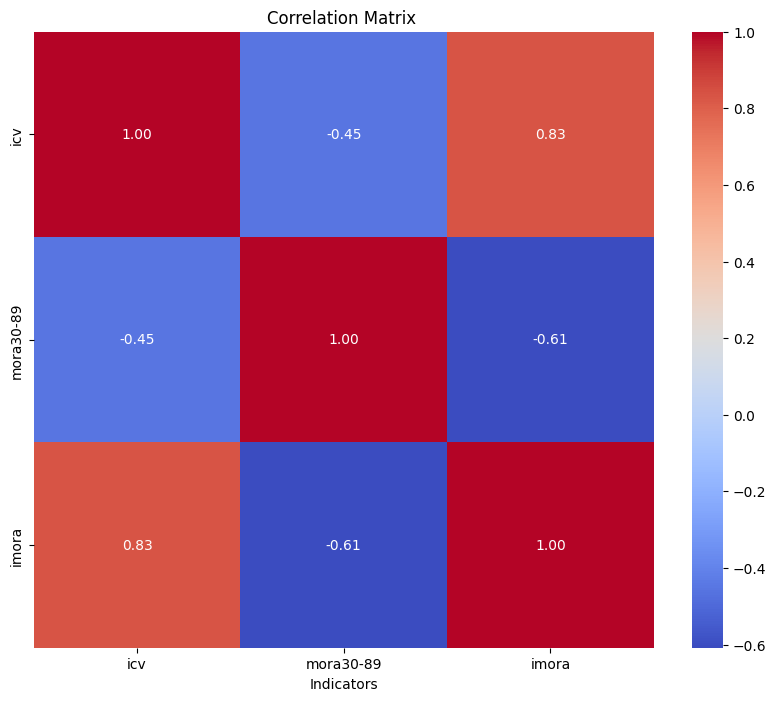

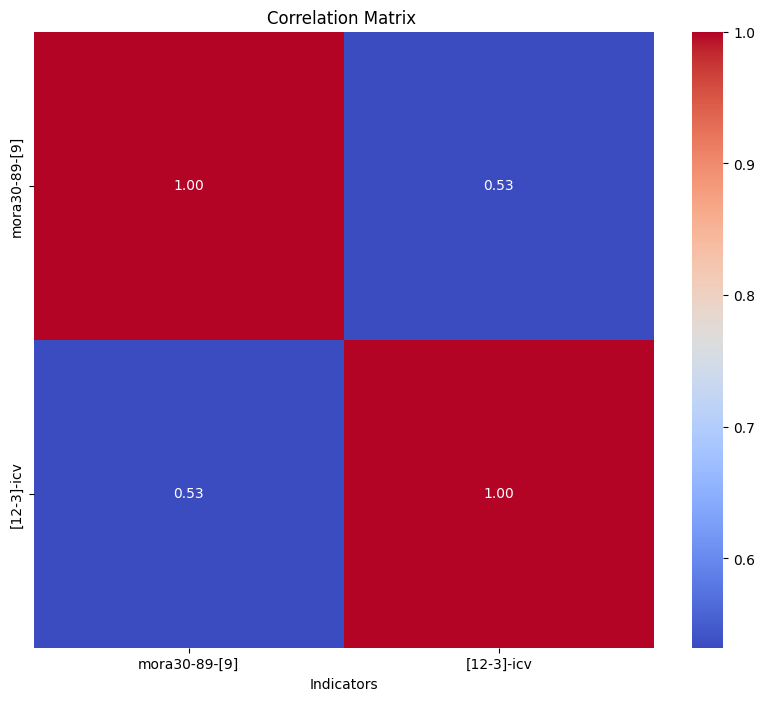

In [73]:
def correlation_matrix_between_datasets(x):
    # B
    x=x.iloc[:,:]

    # Initialize a DataFrame to store the correlation matrix
    correlation_matrix = pd.DataFrame(index=x.columns, columns=x.columns)
    x.head()

    # Calculate the Pearson correlation coefficient for each pair of columns
    correlation_matrix=x.corr()

    # Convert the values to numeric
    correlation_matrix = correlation_matrix.astype(float)

    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix ")
    plt.xlabel("Indicators")
    plt.show()

    return correlation_matrix

correlation_matrix = correlation_matrix_between_datasets(matrix)
correlation_matrix = correlation_matrix_between_datasets(matriz1)